In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

import numpy as np

from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from keras import backend as K

K.set_session(
    K.tf.Session(
        config=K.tf.ConfigProto(
            intra_op_parallelism_threads=32,
            inter_op_parallelism_threads=32)
    )
)

import tensorflow as tf
print(tf.__version__)

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

adf = pd.read_csv('./data/info-latching/seq_len_10.csv')

# -1: not counting label column
seq_len = adf.shape[1] - 1
N = adf.shape[0]
batch_size = 100

train_xs = adf.drop('label', axis=1).values.reshape(N, seq_len, 1)

train_ys = adf.label.values

Using TensorFlow backend.


1.7.0


In [2]:
inputs = Input(shape=(None, 1), name='input')
rnn = SimpleRNN(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
# dense = Dense(2, activation='softmax', name='output')
dense = Dense(1, activation='sigmoid', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
optm = Adam(lr=1e-3, clipnorm=1)
# optm = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optm, loss='mse', metrics=['accuracy'])
hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=30,
                 validation_split=0.2, 
                 verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 5s 587us/step - loss: 0.1788 - acc: 0.9848 - val_loss: 0.1630 - val_acc: 0.9970
Epoch 2/30
8000/8000 [==============================] - 0s 38us/step - loss: 0.1482 - acc: 0.9993 - val_loss: 0.1343 - val_acc: 1.0000
Epoch 3/30
8000/8000 [==============================] - 0s 41us/step - loss: 0.1229 - acc: 1.0000 - val_loss: 0.1125 - val_acc: 1.0000
Epoch 4/30
8000/8000 [==============================] - 0s 38us/step - loss: 0.1039 - acc: 1.0000 - val_loss: 0.0961 - val_acc: 1.0000
Epoch 5/30
8000/8000 [==============================] - 0s 38us/step - loss: 0.0894 - acc: 1.0000 - val_loss: 0.0832 - val_acc: 1.0000
Epoch 6/30
8000/8000 [==============================] - 0s 36us/step - loss: 0.0779 - acc: 1.0000 - val_loss: 0.0729 - val_acc: 1.0000
Epoch 7/30
8000/8000 [==============================] - 0s 37us/step - loss: 0.0685 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 1.0000
Epoch 

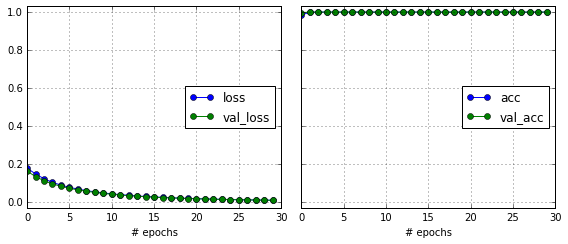

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3.5))
axes = axes.ravel()

for k, keys in enumerate([['loss', 'val_loss'], ['acc', 'val_acc']]):
    ax = axes[k]
    
    for key in keys:
        ax.plot(hist.history[key], 'o-', label=key)
    ax.grid()
    ax.legend(loc='center right')
    ax.set_ylim(-0.03, 1.03)
    ax.set_xlabel('# epochs')
plt.tight_layout()

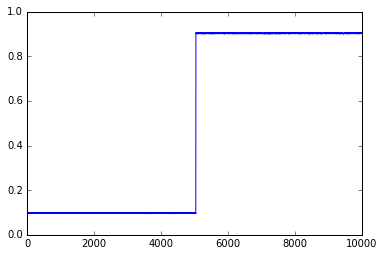

In [4]:
plt.plot(model.predict(train_xs[np.argsort(train_ys)]))

Seems the divide can't be as crisp as that of GRU/LSTM

In [5]:
wx = rnn.get_weights()[0].ravel()[0]
wh = rnn.get_weights()[1].ravel()[0]
bias = rnn.get_weights()[2].ravel()[0]
print(wx, wh, bias)

-0.30553803 -1.7851336 -0.0005210159


In [6]:
np.tanh(wh * (0.5) + bias)

-0.7129155150235831

About to shift between 0.5 and -0.5; Similarly in the GRU case, it shifts between 1 and -1

In [7]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[2.3954382] [-0.00139212]


[0.09912986] [[0.09912986]]
[0.09785988] [[0.09785988]]
[0.09850166] [[0.09850166]]
[0.09645119] [[0.09645119]]


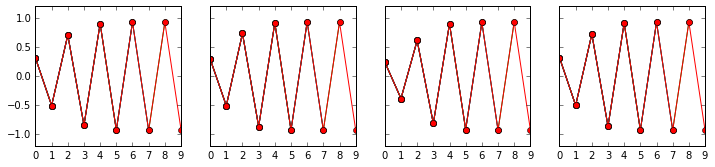

In [8]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 2.5))
axes = axes.ravel()

for k, single_x in enumerate([train_xs[0], train_xs[1], train_xs[-2], train_xs[-1]]):
    ax = axes[k]
    h_prev = 0
    hist = []
    for t in range(single_x.shape[0]):
        cat_x = [h_prev, single_x[t][0]]
        _out = np.tanh(np.dot([wh, wx], cat_x) + bias)
        hist.append(_out)
        h_prev = _out
        ax.plot(hist, 'o-')
    den_in = hist[-1]
    out = sigmoid(den_in * d_w0 + d_b0)
    # mannually calculated output should match that of the model prediction, 
    # so that it means the mannual process is correct
    print(out, model.predict(np.array([single_x])))
    ax.set_ylim(-1.2, 1.2)